In [1]:
from pykrx import stock
import mpl_finance

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import arrow
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

/Users/minseop/.pyenv/versions/3.8.5/envs/env_stock_bot/lib/python3.8/site-packages/mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


In [2]:
# constant variables
TRAINING_DAYS = 1080
DAYS_FOR_PREDICTION = 7

In [3]:
def get_stock_info_dataframe(end_date, start_date, ticker):
    df = stock.get_market_ohlcv_by_date(fromdate=start_date, todate=end_date, ticker=ticker)
    df = df.rename(columns={
                      '시가': 'open',
                      '고가': 'high',
                      '저가': 'low',
                      '종가': 'close',
                      '거래량': 'volume'})
    
    open_next_day = []
    high_next_day = []
    low_next_day = []
    close_next_day = []
    volume_next_day = []
    
    open_days_ago = []
    high_days_ago = []
    low_days_ago = []
    close_days_ago = []
    volume_days_ago = []

    for ago_days in range(0, DAYS_FOR_PREDICTION):
        open_days_ago.append([])
        high_days_ago.append([])
        low_days_ago.append([])
        close_days_ago.append([])
        volume_days_ago.append([])
    
    
    for i in range(DAYS_FOR_PREDICTION-1, len(df)-1):
        open_next_day.append(df.iloc[i+1]['open'])
        high_next_day.append(df.iloc[i+1]['high'])
        low_next_day.append(df.iloc[i+1]['low'])
        close_next_day.append(df.iloc[i+1]['close'])
        volume_next_day.append(df.iloc[i+1]['volume'])
        
        for ago_days in range(1, DAYS_FOR_PREDICTION):
            open_days_ago[ago_days].append(df.iloc[i-ago_days]['open'])
            high_days_ago[ago_days].append(df.iloc[i-ago_days]['high'])
            low_days_ago[ago_days].append(df.iloc[i-ago_days]['low'])
            close_days_ago[ago_days].append(df.iloc[i-ago_days]['close'])
            volume_days_ago[ago_days].append(df.iloc[i-ago_days]['volume'])

    df = df.iloc[DAYS_FOR_PREDICTION-1:len(df)-1,]
    for ago_days in range(1, DAYS_FOR_PREDICTION):
        df[f'open_{ago_days}day_ago'] = open_days_ago[ago_days]
        df[f'high_{ago_days}day_ago'] = high_days_ago[ago_days]
        df[f'low_{ago_days}day_ago'] = low_days_ago[ago_days]
        df[f'close_{ago_days}day_ago'] = close_days_ago[ago_days]
        df[f'volume_{ago_days}day_ago'] = volume_days_ago[ago_days]
    
    df['open_next_day'] = open_next_day
    df['high_next_day'] = high_next_day
    df['low_next_day'] = low_next_day
    df['close_next_day'] = close_next_day
    df['volume_next_day'] = volume_next_day

    return df

In [4]:
# ticker=005930: Samsung Electronics
# ticker=000660: Hynix
end_date = arrow.utcnow().shift(hours=9).format('YYYYMMDD')
start_date = arrow.get(end_date).shift(days=-TRAINING_DAYS).format('YYYYMMDD')

df = get_stock_info_dataframe(end_date, start_date, '005930')
df_train = df.iloc[0:len(df)-70]
df_test = df.iloc[len(df)-70:]

In [15]:
def draw_candle_chart(df_stock_info, title, postfix=''):
    DATE_TICK_RANGE = int(len(df_stock_info)/9)
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111)
    ax.set_title(title)

    day_list = range(len(df_stock_info))
    name_list = []

    cnt = 0
    for day in df_stock_info.index:
        name_list.append(arrow.get(day).format('YYYY-MM-DD')) if cnt % DATE_TICK_RANGE == 0 else name_list.append('')
        cnt = cnt + 1

    ax.xaxis.set_major_locator(ticker.FixedLocator(day_list))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(name_list))

    mpl_finance.candlestick2_ohlc(ax, df_stock_info['open'+postfix], df_stock_info['high'+postfix],
                                  df_stock_info['low'+postfix], df_stock_info['close'+postfix], width=0.5, colorup='r', colordown='b')
    plt.show()

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split
import random

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor

In [7]:
x1_train, x1_test, y1_train, y1_test = train_test_split(df_train.loc[:, [col for col in df_train.columns if col not in ['open_next_day', 'high_next_day', 'low_next_day', 'close_next_day', 'volume_next_day']]],
                                                        df_train[['open_next_day', 'high_next_day', 'low_next_day', 'close_next_day']],
                                                        random_state=random.randrange(1, 100))

In [8]:
pipe = Pipeline([('preprocessing', None), ('regressor', LinearRegression())])
pre_list = [StandardScaler(), MinMaxScaler(), None]
hyperparam_grid = [
    {'regressor': [LinearRegression()], 'preprocessing': pre_list},
    {'regressor': [Ridge()], 'preprocessing': pre_list,
     'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
    {'regressor': [Lasso()], 'preprocessing': pre_list,
     'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
    {'regressor': [LogisticRegression()], 'preprocessing': pre_list,
     'regressor__C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
    {'regressor': [SVR()], 'preprocessing': pre_list,
     'regressor__epsilon': [0.001, 0.01, 0.1, 1, 10],
     'regressor__C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
    {'regressor': [MLPRegressor()], 'preprocessing': pre_list,
     'regressor__hidden_layer_sizes': [(100,) , (10, 10, )],
     'regressor__activation': ['relu', 'logistic'],
     'regressor__solver': ['lbfgs', 'adam'],
     'regressor__alpha': [0.0001, 0.01, 1]},
    {'regressor': [XGBRegressor(objective='reg:squarederror')],
     'preprocessing': pre_list,
     'regressor__learning_rate': [0.0, 0.1, 0.09, 0.089, 0.08],
     'regressor__booster': ['gbtree', 'gblinear', 'dart']}

]
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

grid1 = GridSearchCV(pipe, hyperparam_grid, scoring='neg_mean_absolute_error',
                     refit=True, cv=kfold)

In [9]:
import time
start_time = time.time()
grid1.fit(x1_train, y1_train)
print(grid1.best_estimator_)
print(grid1.best_params_)
print(-grid1.best_score_)
print(-grid1.score(x1_test, y1_test))
print('training time %f sec' % (time.time() - start_time ))

Pipeline(steps=[('preprocessing', MinMaxScaler()),
                ('regressor', Lasso(alpha=10))])
{'preprocessing': MinMaxScaler(), 'regressor': Lasso(alpha=10), 'regressor__alpha': 10}
594.1557892137563
569.6940239518858
training time 75.940094 sec


In [10]:
df_test = df_test[[col for col in df_test.columns if col not in ['open_next_day', 'high_next_day', 'low_next_day', 'close_next_day', 'volume_next_day']]]
next_day_prediction = grid1.best_estimator_.predict(df_test)

df_test = df_test.iloc[0:len(df_test)-1]

columns = ['open_next_day', 'high_next_day', 'low_next_day', 'close_next_day']
df_test_result = pd.DataFrame(next_day_prediction, columns=columns)
df

,open,high,low,close,volume,open_1day_ago,high_1day_ago,low_1day_ago,close_1day_ago,volume_1day_ago,...,open_6day_ago,high_6day_ago,low_6day_ago,close_6day_ago,volume_6day_ago,open_next_day,high_next_day,low_next_day,close_next_day,volume_next_day
날짜,,,,,,,,,,,,,,,,,,,,,
2018-09-17,45550,45800,44900,45150,8123384,45000,45850,44900,45850,12446344,...,44500,45200,44400,44900,18285508,44950,45900,44700,45500,9987090
2018-09-18,44950,45900,44700,45500,9987090,45550,45800,44900,45150,8123384,...,45450,45550,45000,45500,9979838,46000,46200,45700,46150,9367454
2018-09-19,46000,46200,45700,46150,9367454,44950,45900,44700,45500,9987090,...,45550,45900,45050,45050,9865790,46850,47600,46400,47250,13536966
2018-09-20,46850,47600,46400,47250,13536966,46000,46200,45700,46150,9367454,...,44900,45100,44500,44550,12995269,46550,47550,46550,47400,14476906
2018-09-21,46550,47550,46550,47400,14476906,46850,47600,46400,47250,13536966,...,44550,44750,44000,44050,18277942,46950,47500,46450,47500,15804586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-12,77100,78200,76900,77000,42365223,79600,79800,78500,78500,30241137,...,82200,83100,81800,82900,25642368,75800,76000,74100,74400,61270643
2021-08-13,75800,76000,74100,74400,61270643,77100,78200,76900,77000,42365223,...,83300,83300,82000,82100,18485469,74000,75100,74000,74200,30944847
2021-08-17,74000,75100,74000,74200,30944847,75800,76000,74100,74400,61270643,...,81900,82500,81300,81500,13342623,73900,74600,73100,73900,29192631


In [11]:
df_test = df_test[[col for col in df_test.columns if col not in ['open_next_day', 'high_next_day', 'low_next_day', 'close_next_day', 'volume_next_day']]]
next_day_prediction = grid1.best_estimator_.predict(df_test)

df_test_curr = df_test.iloc[0:len(df_test)-1]

columns = ['open_prediction', 'high_prediction', 'low_prediction', 'close_prediction']
df_test_result = pd.DataFrame(next_day_prediction, columns=columns)
df_test_result = df_test_result.iloc[1:len(df_test_result)]
print(df_test_result)
df_test_curr = df_test_curr.drop([col for col in df_test_curr.columns if 'ago' in col], axis=1)

df_test_result.index = df_test_curr.index
df_test_merged= pd.concat([df_test_result, df_test_curr], axis=1)
df_test_merged


    open_prediction  high_prediction  low_prediction  close_prediction
1      78554.868002     79377.334381    77890.636974      78592.452268
2      79981.754180     80832.177709    79253.937276      79997.134280
3      79656.480620     80610.631013    78920.389201      79775.826129
4      79667.784513     80596.623528    78900.118895      79751.769835
5      79566.490728     80435.286289    78821.247097      79649.024445
..              ...              ...             ...               ...
64     78588.756374     79493.113575    77910.907280      78697.331327
65     77060.962404     78001.397985    76403.505415      77148.750919
66     74453.046735     75596.926704    73785.270102      74557.490267
67     74276.296640     75120.788964    73607.256200      74328.764408
68     73917.226899     74920.954456    73188.208055      74004.990743

[68 rows x 4 columns]


,open_prediction,high_prediction,low_prediction,close_prediction,open,high,low,close,volume
날짜,,,,,,,,,
2021-05-12,78554.868002,79377.334381,77890.636974,78592.452268,80800,81200,79800,80000,35812268
2021-05-13,79981.754180,80832.177709,79253.937276,79997.134280,78900,79600,78400,78500,31490096
2021-05-14,79656.480620,80610.631013,78920.389201,79775.826129,79000,80300,78900,80100,16450920
2021-05-17,79667.784513,80596.623528,78900.118895,79751.769835,80800,80900,79200,79600,17740855
2021-05-18,79566.490728,80435.286289,78821.247097,79649.024445,79600,80000,79100,79600,17494407
...,...,...,...,...,...,...,...,...,...
2021-08-10,78588.756374,79493.113575,77910.907280,78697.331327,82300,82400,80100,80200,20362639
2021-08-11,77060.962404,78001.397985,76403.505415,77148.750919,79600,79800,78500,78500,30241137
2021-08-12,74453.046735,75596.926704,73785.270102,74557.490267,77100,78200,76900,77000,42365223


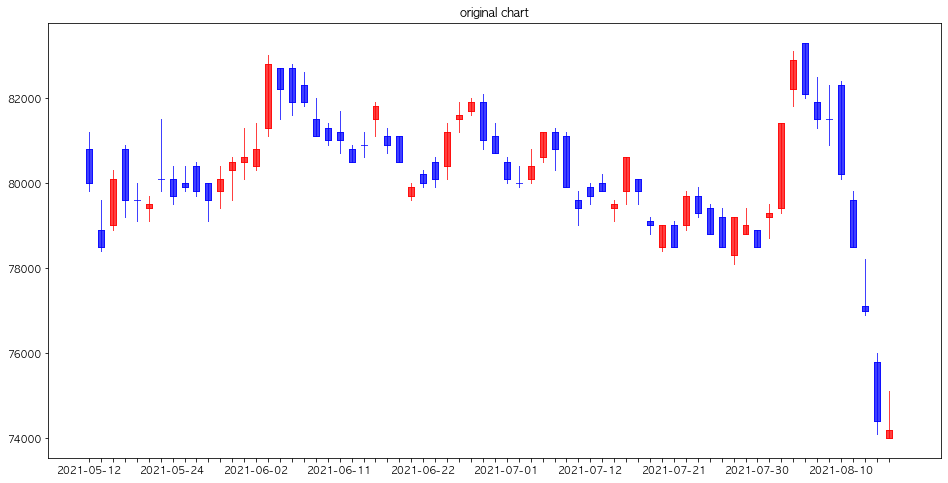

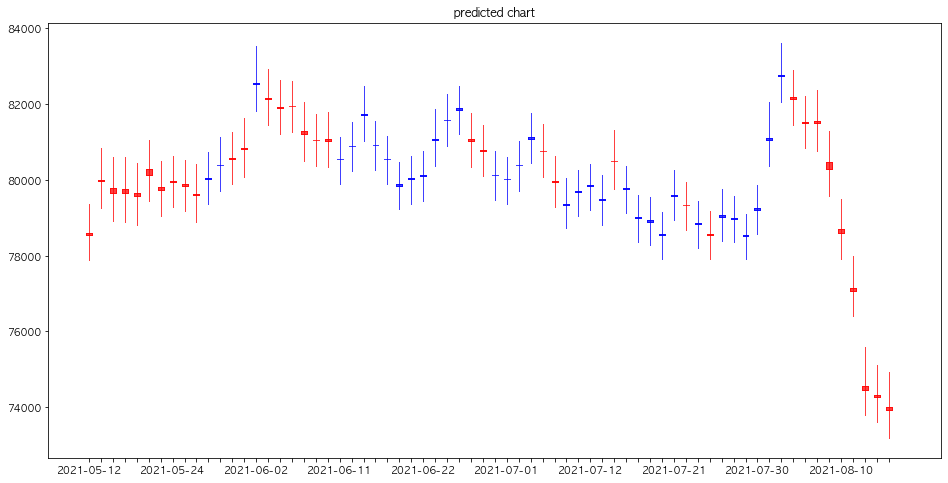

In [16]:
draw_candle_chart(df_test_merged, 'original chart')
draw_candle_chart(df_test_merged, 'predicted chart', postfix='_prediction')

In [ ]:
def get_stock_info_dataframe(end_date, start_date, ticker):
    df = stock.get_market_ohlcv_by_date(fromdate=start_date, todate=end_date, ticker=ticker)
    df = df.rename(columns={
                      '시가': 'open',
                      '고가': 'high',
                      '저가': 'low',
                      '종가': 'close',
                      '거래량': 'volume'})
    
    open_next_day = []
    high_next_day = []
    low_next_day = []
    close_next_day = []
    volume_next_day = []
    
    open_days_ago = []
    high_days_ago = []
    low_days_ago = []
    close_days_ago = []
    volume_days_ago = []

    for ago_days in range(0, DAYS_FOR_PREDICTION):
        open_days_ago.append([])
        high_days_ago.append([])
        low_days_ago.append([])
        close_days_ago.append([])
        volume_days_ago.append([])
    
    
    for i in range(DAYS_FOR_PREDICTION-1, len(df)-1):
        open_next_day.append(df.iloc[i+1]['open'])
        high_next_day.append(df.iloc[i+1]['high'])
        low_next_day.append(df.iloc[i+1]['low'])
        close_next_day.append(df.iloc[i+1]['close'])
        volume_next_day.append(df.iloc[i+1]['volume'])
        
        for ago_days in range(1, DAYS_FOR_PREDICTION):
            open_days_ago[ago_days].append(df.iloc[i-ago_days]['open'])
            high_days_ago[ago_days].append(df.iloc[i-ago_days]['high'])
            low_days_ago[ago_days].append(df.iloc[i-ago_days]['low'])
            close_days_ago[ago_days].append(df.iloc[i-ago_days]['close'])
            volume_days_ago[ago_days].append(df.iloc[i-ago_days]['volume'])

    df = df.iloc[DAYS_FOR_PREDICTION-1:len(df)-1,]
    for ago_days in range(1, DAYS_FOR_PREDICTION):
        df[f'open_{ago_days}day_ago'] = open_days_ago[ago_days]
        df[f'high_{ago_days}day_ago'] = high_days_ago[ago_days]
        df[f'low_{ago_days}day_ago'] = low_days_ago[ago_days]
        df[f'close_{ago_days}day_ago'] = close_days_ago[ago_days]
        df[f'volume_{ago_days}day_ago'] = volume_days_ago[ago_days]
    
    df['open_next_day'] = open_next_day
    df['high_next_day'] = high_next_day
    df['low_next_day'] = low_next_day
    df['close_next_day'] = close_next_day
    df['volume_next_day'] = volume_next_day

    return df